# Predict Blood Donation for Future Expectancy

Forecasting blood supply is a serious and recurrent problem for blood collection managers: in January 2019, "Nationwide, the Red Cross saw 27,000 fewer blood donations over the holidays than they see at other times of the year." Machine learning can be used to learn the patterns in the data to help to predict future blood donations and therefore save more lives.

In this Project, we will work with data collected from the donor database of Blood Transfusion Service Center in Hsin-Chu City in Taiwan. The center passes its blood transfusion service bus to one university in Hsin-Chu City to gather blood donated about every three months. The dataset, obtained from the UCI Machine Learning Repository, consists of a random sample of 748 donors. 

Our task will be to predict if a blood donor will donate within a given time window. WE will look at the full model-building process: from inspecting the dataset to using the tpot library to automate your Machine Learning pipeline.

#### Importing necessray libraries

In [219]:
import pandas as pd
import numpy as np
import os

In [220]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 0.20.3.


#### Loading the blood donations data

In [221]:
inp_file="transfusion.data"
data=pd.read_csv(inp_file)

#### Inspecting transfusion DataFrame

In [222]:
data.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [223]:
data.shape

(748, 5)

In [224]:
data.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [225]:
data.isnull().sum()

Recency (months)                              0
Frequency (times)                             0
Monetary (c.c. blood)                         0
Time (months)                                 0
whether he/she donated blood in March 2007    0
dtype: int64

#### Checking the variance and Log normalization¶

In [226]:
data.var()

Recency (months)                              6.553543e+01
Frequency (times)                             3.409751e+01
Monetary (c.c. blood)                         2.131094e+06
Time (months)                                 5.942242e+02
whether he/she donated blood in March 2007    1.815819e-01
dtype: float64

#### Variance is very high for Monetary. Hence doing log normalization

In [227]:
data['log_Monetary']=np.log(data['Monetary (c.c. blood)'])

In [277]:
data.head()

,Recency (months),Frequency (times),Time (months),target,log_Monetary
0,2,50,98,1,9.433484
1,0,13,28,1,8.086410
2,1,16,35,1,8.294050
3,2,20,45,1,8.517193
4,1,24,77,0,8.699515


In [228]:
data.var()

Recency (months)                              6.553543e+01
Frequency (times)                             3.409751e+01
Monetary (c.c. blood)                         2.131094e+06
Time (months)                                 5.942242e+02
whether he/she donated blood in March 2007    1.815819e-01
log_Monetary                                  8.363484e-01
dtype: float64

In [229]:
Monetary=data.pop('Monetary (c.c. blood)')

#### Creating target column

In [230]:
data.rename(columns={"whether he/she donated blood in March 2007":"target"},inplace=True)

In [231]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
Recency (months)     748 non-null int64
Frequency (times)    748 non-null int64
Time (months)        748 non-null int64
target               748 non-null int64
log_Monetary         748 non-null float64
dtypes: float64(1), int64(4)
memory usage: 29.3 KB


In [232]:
features=['Recency (months)','Frequency (times)','Time (months)','log_Monetary']

#### Checking target incidence

In [233]:
data['target'].value_counts()

0    570
1    178
Name: target, dtype: int64

In [234]:
perc_zero= (data[data['target']== 0].shape[0]/data.shape[0])*100
print(perc_zero)

76.20320855614973


In [235]:
perc_one= (data[data['target']== 1].shape[0]/data.shape[0])*100
print(perc_one)

23.796791443850267


####  Class imbalance is present in teh dataset and hence need to be addressed while modeling to get accurate results

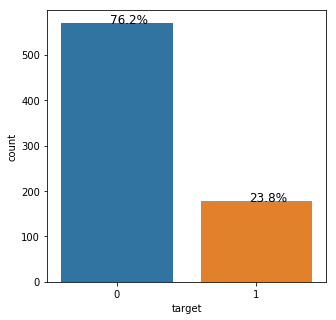

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns

def annotate_plot(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

plt.figure(figsize=(5,5))    
ax=sns.countplot(x='target', data=data)    
annotate_plot (ax,data.target) 

#### Splitting transfusion into train and test datasets

In [237]:
y=data['target']
X=data[features]

In [238]:
y.head()

0    1
1    1
2    1
3    1
4    0
Name: target, dtype: int64

In [239]:
#X.head()

In [240]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

In [241]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

C:\Users\SHARIE R NATH\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\SHARIE R NATH\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\SHARIE R NATH\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [242]:
X_train.shape

(501, 4)

In [243]:
X_test.shape

(247, 4)

In [244]:
y_train.shape

(501,)

In [245]:
y_test.shape

(247,)

In [246]:
X_train

array([[ 0.5098723 , -0.80215192, -0.90544114, -1.48224973],
       [-0.91521012, -0.80215192, -1.39726551, -1.48224973],
       [ 0.74738604, -0.4659929 , -0.70051432, -0.2741567 ],
       ...,
       [-0.91521012,  1.55096124,  0.52904661,  1.49566759],
       [ 1.57868412,  1.55096124,  0.85692952,  1.49566759],
       [ 0.74738604, -0.29791339, -0.53657286,  0.04219394]])

#### Splitting transfusion into train and test datasets

In [210]:
from tpot import TPOTClassifier

In [211]:
#pip install tpot

In [159]:
import tpot
tpot.__version__

'0.10.2'

In [213]:
pipeline_optimizer = TPOTClassifier(scoring='accuracy',generations=10, population_size=20, cv=10,
                                    random_state=42, verbosity=2)
pipeline_optimizer.fit(X_train, y_train)

Version 0.10.2 of tpot is outdated. Version 0.11.7 was released Wednesday January 06, 2021.


Generation 1 - Current best internal CV score: 0.7964561824729892
Generation 2 - Current best internal CV score: 0.8044169667867148
Generation 3 - Current best internal CV score: 0.8044169667867148
Generation 4 - Current best internal CV score: 0.8044561824729893
Generation 5 - Current best internal CV score: 0.8044561824729893
Generation 6 - Current best internal CV score: 0.8044561824729893
Generation 7 - Current best internal CV score: 0.8044561824729893
Generation 8 - Current best internal CV score: 0.8044561824729893
Generation 9 - Current best internal CV score: 0.8044561824729893
Generation 10 - Current best internal CV score: 0.8044561824729893

Best pipeline: LogisticRegression(PolynomialFeatures(PCA(input_matrix, iterated_power=6, svd_solver=randomized), degree=2, include_bias=False, interaction_only=False), C=10.0, dual=False, penalty=l1)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=10,
        disable_update_check=False, early_stop=None, generations=10,
        max_eval_time_mins=5, max_time_mins=None, memory=None,
        mutation_rate=0.9, n_jobs=1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=20,
        random_state=42, scoring='accuracy', subsample=1.0, template=None,
        use_dask=False, verbosity=2, warm_start=False)

In [169]:
print("Train_score:",exported_pipeline.score(X_train,y_train))
print("Test_score:",exported_pipeline.score(X_test, y_test))
pipeline_optimizer.export('tpot_exported_pipeline.py')

Train_score: 0.9101796407185628
Test_score: 0.757085020242915


In [269]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


exported_pipeline = make_pipeline(
     PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
     LogisticRegression(C=10.0, dual=True, penalty="l2")
)
exported_pipeline.fit(X_train, y_train)
print("Train_score:",exported_pipeline.score(X_train,y_train))
print("Test_score:",exported_pipeline.score(X_test, y_test))
results = exported_pipeline.predict(X_test)

C:\Users\SHARIE R NATH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\SHARIE R NATH\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train_score: 0.8063872255489022
Test_score: 0.7894736842105263


In [270]:
from sklearn.metrics import classification_report
print(classification_report(y_test, results))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       188
           1       0.62      0.31      0.41        59

   micro avg       0.79      0.79      0.79       247
   macro avg       0.72      0.62      0.64       247
weighted avg       0.77      0.79      0.76       247



### Training the model

In [256]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [263]:
exported_pipeline = make_pipeline(
     LogisticRegression(C=10, dual=True, penalty="l2")

)


exported_pipeline=LogisticRegression(C=30, dual=False)

In [271]:
exported_pipeline.fit(X_train, y_train)
print("Train_score:",exported_pipeline.score(X_train,y_train))
results = exported_pipeline.predict(X_test)
print("Test_score:",exported_pipeline.score(X_test, y_test))

C:\Users\SHARIE R NATH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\SHARIE R NATH\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train_score: 0.8063872255489022
Test_score: 0.7894736842105263


##### from sklearn.metrics import classification_report
print(classification_report(y_test, results))

In [275]:
import pickle
#Fitting model with trainig data
exported_pipeline.fit(X_train, y_train)
db_file=open('model.pkl','wb')
pickle.dump(exported_pipeline,db_file )
db_file.close()

C:\Users\SHARIE R NATH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\SHARIE R NATH\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [279]:
# Loading model to compare the results
db_file=open('model.pkl','rb')
prediction = pickle.load(db_file)
print(prediction.predict([[2,16,13,6.2]]))
db_file.close()

[0]
